# <center>Sequence-to-Sequence Learning with Neural Networks</center>

1. [What is a sequence to sequence network ?](#sec1)
2. [How is it made ?](#sec2)
    1. [Principles](#sec2-A)
    2. [Why do we use RNNs ?](#sec2-B)
    3. [LSTM and GRU](#sec2-C)
    4. [Recap](#sec2-D)
    5. [Attention](#sec2-E)
3. [Let's do a French to English translator](#sec3)
    1. [Preprocess the data](#sec3-1)
    2. [The model](#sec3-2)
    3. [Functions to Vectorize the training data](#sec3-3)
    4. [Training the model](#sec3-4)
    5. [Evaluation](#sec3-5)


The pytorch library is required for this notebook.

In this notebook, we will look at the sequence-to-sequence model. Through its architecture, we will see its principles, these different neural network cells, and the principle of attention. A practical application will conclude this notebook by a French to English sequence-to-sequence translator, adapted from the pyTorch tutorial "NLP From Scratch: Translation with a Sequence to Sequence Network and Attention". 

# 1. <a id="sec1"></a>What is a Sequence-to-Sequence model ?

<i>Sequence-to-Sequence</i> (abrv. Seq2Seq) models are deep learning models that take a sequence of items (sentences, medical signals, speech waveforms, time-series, …) and output another sequence of items, hence its name "sequence to sequence".

<video width="852" height="480" controls src="Images/seq2seq_1.mp4" />

The model is explained in the pioneering paper : [Sutskever et al., 2014](http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) (pretty new !).

Sequence to sequence models have proven their effectiveness for many tasks and can be used in machine translation, articles and books summarization, image captioning, speech recognition, waveforms/time-series forecasting, predicting stock market trends, handwriting generation and many more ! 

In the case of Neural Machine Translation, the input is a series of words, and the output is the translated series of words. Until 2014, [Statistical Machine Translation](https://en.wikipedia.org/wiki/Statistical_machine_translation) was by far the most widely used machine translation method, using statistical models. The introduction of [Neural Machine Translation](https://en.wikipedia.org/wiki/Neural_machine_translation) has significantly increased performance, and for instance Google introduced in November 2016 its new [Google Neural Machine Translation](https://en.wikipedia.org/wiki/Google_Neural_Machine_Translation) for Google Translate.

<video width="852" height="480" controls src="Images/seq2seq_mt.mp4" />

# 2. <a id="sec2"></a>How is it made ?

### A. <a id="sec2-A"></a>Principles

A seq2seq network is generally made of two neural networks. The first one is an **encoder**, which encodes an input sequence to a fixed-length context vector (you can think of the context vector as being an abstract representation of the entire input sentence, we will talk more about his context vector later). The second one is a **decoder** which receives this context vector and learns to output the target (output) sequence by generating it one item at a time.

<video width="852" height="480" controls src="Images/seq2seq_2.mp4" />

Note that the input is **3** circles, and the output is **4** triangles. 

Indeed, for tranlation for example, the length of the input sequence in language A is not necessarily equal to the length of the output sequence in language B. "Je suis étudiant" (3 words) becomes "I am a student" (4 words). A seq2seq model is able to take a variable-length sequence as an input, and return a variable-length sequence as an output, using a fixed-sized model by encoding many inputs into one vector, and decoding from one vector into many outputs.

In order to two that, the encoder and decoder neural networks are (commonly) **RNNs (Recurrent Neural Networks)**.

###  <a id="sec2-B"></a>B. Why RNNs ?

##### - Long-term dependencies

Remember, as we have seen with Denis with the Time-series Forecasting notebook, recurrent neural networks depend on the previous state for the current state's computation. 

Instead of simply prediction $Y = f(x)$ as in feed-forward neural networks, recurrent networks do $Y_1 = f(x_1, f(x_0))$.

<img src="Images/unrolled_rnn.png"/>

You can see that at every point in time, it takes as input its own previous state and the new input at that time step.
<div class="alert alert-success">
RNNs keep information about their previous state.
</div>

Each state is a function of the previous state, which is the function of its previous state, and so on. So, state n contain information from all past timesteps. And we need this to predict sequences. Indeed, elements in the sequences and the order of these elements have a strong relationship. For machine translation, a sentence contains words in a certain order and some of which have a strong influence on others. 

For example, let's translate using Google Translate "Je surveille mes actions tous les jours" in english :

<img src="Images/mt_ex_1.png"/>

Now, let's translate "A la bourse, je surveille mes actions tous les jours" :

<img src="Images/mt_ex_2.png"/>

See how "actions" becomes "stocks" thanks to the memory of the RNN when we add the stock market context at the beginning of the sentence.

##### - Variable-length sequence

The two RNNS working together frees us from sequence length which makes it ideal for translation between two languages and opens a whole new range of problems which can be solved using such architecture. How a sequence starts and ends ? Example with a german to english translator:

<img src="Images/sos-eos.png"/>

The model takes as input a sequence starting with the SOS (Start Of Sequence) token and ending with the EOS (End Of Sequence) token. As long as the decoder doesn't predict the EOS token, the size of the output sequence can increase.

###  <a id="sec2-C"></a>C. LSTM and GRU

We've talked about RNNs that keep track of temporal dependencies. In reality, simple RNNs can have difficulty handling long-term dependencies. Imagine a sequence problem that involves predicting a word in a sentence. Example : "In France, I had a great time and I learnt some of the ______ language." The information of the word "France" can be found in hidden states but often is already too abstract. 

Moreover, when learning, in some cases the gradient can be very small and can prevent the network weights from changing value. Traditional activation functions such as the hyperbolic tangent function have gradients in the range (-1, 1). Thus, the backpropagation trough time calculates gradients by multiplying very small numbers. And the more we calculate the errors due to further and further back time steps, the smaller and smaller the gradients will be, because of the product of small numbers. Parameters of the simple RNN become biased to capture short-term dependencies. This is called the [Vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).

A seq2seq model could use more complex recurrent neural networks without this problem, such as **LSTM (Long Short-Term Memory)** or a **GRU (Gated Recurrent Unit)**. 

##### - LSTM
As we saw with Denis with the Time-series Forecasting notebook, a LSTM is a more complex RNN explicitly designed to avoid the long-term dependency problem. Instead of just taking in a hidden state and returning a new hidden state per time-step, a LSTM cell take in and return a separate cell state, $c_t$, per time-step.

<div class="alert alert-success">
 $h_t = \text{simpleRNN}(x_t, h_{t-1})\\
 (h_t, c_t) = \text{LSTM}(x_t, (h_{t-1}, c_{t-1}))$
</div>
Example of a LSTM cell :

<img src="Images/lstm-cell.png"/>

$$
i_t = \sigma(W_{xi}x_t + W_{hi}h_{t-1} + b_i)\\
f_t = \sigma(W_{xf}x_t + W_{hf}h_{t-1} +b_f)\\
\tilde{C}_t = \tanh(W_{x\tilde{C}}x_t + W_{h\tilde{C}}h_{t-1} + b_\tilde{C})\\
C_t = f_tc_{t-1}+i_t\tilde{C}_t\\
o_t = \sigma(W_{xo}x_t + W_{ho}h_{t-1}+b_o)\\
h_t = o_t\tanh(c_t)
$$

The key to LSTMs is the cell state, which, in theory, can carry relevant information trhoughout the entire processing of the sequence. The horizontal line running through the cell is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

<img src="Images/lstm-conveyor-belt.png"/>

LSTM, using gates, have the ability to remove or add information to the cell state. Gates are a way to optionally let information through and they can be trained to keep information from long ago. It can keep information in the cell state, which might not be relevant at this time step, but might be relevant at a much later time step. Differents types of LSTM cells exist, if you want to learn more about LSTM, you can read [this blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

<div class="alert alert-success">LSTM cells are able to keep track of information throughout many timesteps.</div>

##### - GRU
A GRU, Gated Recurrent Unit, get rid of the cell state, has only two gates (a reset gate and an update gate) and used only the hidden state to transfer information. GRUs are a little speedier to train than LSTMs. Example of a GRU :

<img src="Images/gru.png"/>

$$
z_t = \sigma(W_{xz}x_t + W_{hz}h_{t-1} +b_z)\\
r_t = \sigma(W_{xr}x_t + W_{hr}h_{t-1} +b_r)\\
h_t = z_t h_{t-1} + (1-z_t)\tanh(W_{xh}x_t + W_{hh}h_{t-1}r_t + b_h)\\
$$

As with LSTMs, there are possible variants of GRU. If you are interested, GRU is the subject of one of AML's notebooks this year (topic number 31), so you can learn more about it.

###  <a id="sec2-D"></a>D. Recap

Here's a animation showing what we have for a seq2seq machine translation model for the moment.

<video width="852" height="480" controls src="Images/seq2seq_4.mp4" />

RNN cells can be simple RNN or LSTM cells or GRU cells.

In theory, the context vector (the final hidden state of the encoder) will contain semantic information about the query sentence that is input to the bot. 
**Problem**: The context vector is responsible for representing the entire input sequence. The output sequence relies heavily on this vector, making it challenging for the model to deal with long sentences. A solution was proposed in the papers [Bahdanau et al., 2014](https://arxiv.org/pdf/1409.0473.pdf) and [Luong et al., 2015](https://arxiv.org/pdf/1508.04025.pdf) : **attention**.

###  <a id="sec2-E"></a>E. Attention

Attention allows the model to focus on the relevant parts of the input sequence at every stage of the output sequence allowing the context to be preserved from beginning to end. Instead of sending only one single hidden state vector to the decoder, we send an attention vector created from a linear combination of all previous hidden states.

<video width="852" height="480" controls src="Images/seq2seq_5.mp4" />

For every step the decoder can select a different part of the input sentence to consider. So, every step, a new attention vector (so a new linear combination) is calculated to be relevant for the decoder.

<video width="852" height="480" controls src="Images/seq2seq_6.mp4" />

For example, the translation of the sentence "L'accord sur la zone économique européènne a été signé en août 1992", we can visualize the attention matrix giving different weights to the hidden states depending on the time step.

<img width="480" height="360"  src="Images/attention.png"/>

You can see how the model, for unambiguous words like "août" or "1992", gives little importance to the other words in the sentence. You can also see that for "zone économique européenne", the model adapts to the reversed order between French and English.

**In a nutshell**, we have seen that a seq2seq model is composed of two RNNs working together, one as an encoder and one as a decoder. These RNNs can be simple, or more complex using LSTM or GRU cells. For the context vector passing from the encoder to the decoder, it consists of all the hidden states of the encoder. For each step, an attention vector is computed to give different importance to the different hidden states, so that the decoder can focus on the relevant parts for the time step under consideration.

# 3. <a id="sec3"></a>Let's do a French to English translator

In [ ]:
#pip install pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re, unicodedata
import random

#setting up device for use with pyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device used is ",device)

## 3.1. <a id="sec3-1"></a>Preprocess the data

In [2]:
import unicodedata
import re
import random

In [3]:
data_path = 'datasets/enfratexts.txt'

In [4]:
SOS_token = 0  # Start-of-sentence token
EOS_token = 1  # End-of-sentence token

We need to vectorize the data. Each unique word we encounter in our dataset will be assigned to a unique index. 

We will first define languages containing all the words in our dataset for the two different languages (similar to what we did in Natural Language Processing notebooks). For this, we use the Lang class. 

**Lang class**
<ul>
<li> maps words to indexes (word2index)
<li> keeps the number of occurences of each word (word2count)
<li> maps indexes to words (index2word)
<li> keeps a total word count of words (n_words)
<li> provides a method for adding a word to the language (addWord)
<li> provides a method for adding all words in a sentence (addSentence)
</ul>

In [5]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Now that we are able to create our languages, we need to build french/english sentence pairs. We must also convert the Unicode strings to ASCII using unicodeToAscii, convert all letters to lowercase and trim all non-letter characters except for basic punctuation (normalizeString). Finally, to aid in training convergence, we will filter out sentences with length greater than the MAX_LENGTH threshold (filterPairs).

For the preprocessing, we are not going to apply Lemmatization or Stemming (cf. NLP courses) because we want to keep the data readable by a human.

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since we want to train something quickly, we’re filtering to sentences that begin with the form "I am" or "He is" etc.

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    pairs = filterPairs(pairs)
    print("%s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(" -", input_lang.name, input_lang.n_words, "words")
    print(" -", output_lang.name, output_lang.n_words, "words")
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print("Example of a pair : ", random.choice(pairs))

So we have 10,599 pairs of sentences, one in French and another one being its English translation.

## <a id="sec3-2"></a>3.2. The model

We will use GRU cells.

**The Encoder**

<img src="Images/encoder-mt.png"/>

<div class="alert alert-warning"><b>Exercice</b><br>
Write the embedding layer and GRU layer code using torch.nn. Think about the dimensions.
</div>

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # Embedding Layer
        #TODO
        
        # GRU Layer
        #TODO

    def forward(self, input, hidden):
        #Embedding the input
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [79]:
# %load corrections/EncoderRNN.py

The embedding layer  is used to represent words by dense vectors where a vector represents the projection of the word into a continuous vector space. Each word in the vocabulary corresponds to a single vector of real numbers of fixed dimension. As we have seen in NLP, this is an improvement over the traditional bag-of-word model.

**The Decoder**

<img src="Images/decoder-mt.png"/>

<div class="alert alert-warning"><b>Exercice</b><br>
    
Write the embedding layer, the GRU layer and the out layer code using torch.nn. The out layer is a linear layer mapping the ouput of the GRU to the output size.
    
Using the decoder's function and the blueprint, write the forward function.
</div>

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        #Embedding Layer
        #TODO
        
        #GRU layer
        #TODO
        
        #Out layer
        #TODO
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        #Embedding the input and applying relu (use F.relu)
        #TODO
        
        #GRU and softmax
        #TODO
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [78]:
# %load corrections/DecoderRNN.py

**The attention**

<img src="Images/attention-mt.png"/>

Note that "BMM" performs a batch matrix-matrix product of matrices.

<div class="alert alert-warning"><b>Exercice</b><br>
    
Write the embedding layer, the linear attn layer, the linear attn_combine layer, and the GRU layer code using torch.nn.
</div>

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p #dropout proba
        self.max_length = max_length
        
        #Embedding layer
        self.embedding = #TODO
        
        #Linear layer
        self.attn = #TODO
        
        #Linear Layer
        self.attn_combine = #TODO
        
        #Dropout
        self.dropout = nn.Dropout(self.dropout_p)
        
        #GRU layer
        self.gru = #TODO
        
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        #First, the input (target sequence) is embedded. Some weights are randomly zeroed out to facilitate
        #learning with the attention mechanism
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        #Attention is computed by combining the context vectors and the embedded input
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        #Attention is applied on the encoded original sentence (in english)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        #We retrieve the embedded input and the context vector (with attention applied), and combine the two tensors
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        #The attended part of the input is fed into the lstm, conditioned by the hidden and cell states
        output, hidden = self.gru(output, hidden)
        #Retrieve token probabilities
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        #In addition to the output and hidden states that are necessary for iterating, we return the attention
        #weights, that will provide some form of explainability
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [80]:
# %load corrections/AttnDecoderRNN.py

You know how to implement a seq2seq model. If you want to reuse this code, you may not need the embedding layers that are useful here because we have words as inputs.

## <a id="sec3-3"></a>3.3. Functions to Vectorize the training data

To train, for each pair we will need an input tensor (index of words in the input sentence) and a target tensor (index of words in the target sentence). When creating these vectors, we will add the EOS token to both sequences.

In [16]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


## <a id="sec3-4"></a>3.4. Training the model

### 3.4.1. One step training

In [17]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    #We pass each input token to the encoder. At each step, we retrive the output and the hidden/cell states,
    #forming the context vector. The context vector is fed back to the encoder for the next step.
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device) #Decoder intilized with a SOS token
    decoder_hidden = encoder_hidden #Passing the context vector from the encoder to the decoder

    # use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break
    
    #Backward propagation
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

### 3.4.2. Plotting loss

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 3.4.3. Multiple training iterations

In [19]:
def trainIters(encoder, decoder, n_iters, print_every=100, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    #Setup optimizers
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # Run train function
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        #Print
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("iter = {0} / {1} = {2:.1f}%, loss avg = {3:.2f}".format(iter, n_iters, iter / n_iters * 100, print_loss_avg))

        #Plot
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### 3.4.4. Training

If you have a GPU, we can see what the training of the model looks like. Else, move on to the next cell...

iter = 100 / 10000 = 1.0%, loss avg = 4.49
iter = 200 / 10000 = 2.0%, loss avg = 3.76
iter = 300 / 10000 = 3.0%, loss avg = 3.59
iter = 400 / 10000 = 4.0%, loss avg = 3.44
iter = 500 / 10000 = 5.0%, loss avg = 3.64
iter = 600 / 10000 = 6.0%, loss avg = 3.33
iter = 700 / 10000 = 7.0%, loss avg = 3.49
iter = 800 / 10000 = 8.0%, loss avg = 3.43
iter = 900 / 10000 = 9.0%, loss avg = 3.22
iter = 1000 / 10000 = 10.0%, loss avg = 3.11
iter = 1100 / 10000 = 11.0%, loss avg = 3.18
iter = 1200 / 10000 = 12.0%, loss avg = 3.14
iter = 1300 / 10000 = 13.0%, loss avg = 3.01
iter = 1400 / 10000 = 14.0%, loss avg = 3.02
iter = 1500 / 10000 = 15.0%, loss avg = 2.97
iter = 1600 / 10000 = 16.0%, loss avg = 2.99
iter = 1700 / 10000 = 17.0%, loss avg = 2.88
iter = 1800 / 10000 = 18.0%, loss avg = 3.01
iter = 1900 / 10000 = 19.0%, loss avg = 2.81
iter = 2000 / 10000 = 20.0%, loss avg = 3.16
iter = 2100 / 10000 = 21.0%, loss avg = 2.76
iter = 2200 / 10000 = 22.0%, loss avg = 2.81
iter = 2300 / 10000 = 23.0%,

<Figure size 432x288 with 0 Axes>

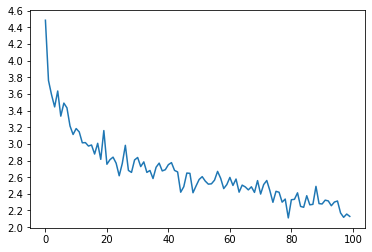

In [72]:
if torch.cuda.is_available() :
    hidden_size = 256

    n_iter = 10000

    encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

    trainIters(encoder, attn_decoder, n_iter)

I've trained a fairly high-performance model beforehand. We can load it directly and avoid waiting for the training which took me about 30 minutes.

In [73]:
#torch.save(encoder,'encoder')
#torch.save(attn_decoder,'attn_decoder')

encoder_2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder_2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

encoder_2 =torch.load('encoder')
attn_decoder_2 = torch.load('attn_decoder')

## <a id="sec3-5"></a>3.5. Evaluation

In [74]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    
    with torch.no_grad(): #Freeze gradient
        
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        # Encoder
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        #Decoder
        decoder_input = torch.tensor([[SOS_token]], device=device)  # Initialize decoder input with the SOS token
        decoder_hidden = encoder_hidden #Feed the encoder context vectors to the decoder
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [75]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder_2, attn_decoder_2)

**Visualizing attention**

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder_2, attn_decoder_2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("je ne suis pas une ivrogne .")
evaluateAndShowAttention("c est vous le doyen .")
evaluateAndShowAttention("je ne suis pas celle que vous pensez .")

As you can see, the model is quite efficient in translation. However, the attention does not seem to be perfectly tuned. It gives importance to words that are not directly correlated to the step in question. To go further, you could try to use LSTM cells instead of GRU, you could also try to use longer sentences and not limit the model to sizes smaller than MAX_LENGTH. You could also try sentences that don't start with predefined prefixes like "i am ", "i m ", "he is", "he s ", etc. You could also use techniques such as "teacher forcing" to improve the model.

# <a id="sources"></a>Sources

- Sequence to Sequence Learning with Neural Networks : [Sutskever et al., 2014](http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)
- Learning Phrase Representations using RNN Encoder–Decoderfor Statistical Machine Translation : [Cho et al., 2014](https://arxiv.org/pdf/1406.1078v3.pdf)
- Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention) : [Jay Alammar, 2018](http://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)
- MIT 6.S191 (2018): Sequence Modeling with Neural Networks : [Harini Suresh's Lecture (Youtube video)](https://www.youtube.com/watch?v=CznICCPa63Q)
- Neural machine translation by jointly learning to align and translate : [Bahdanau et al., 2014](https://arxiv.org/pdf/1409.0473.pdf)
- Effective Approaches to Attention-based Neural Machine Translation : [Luong et al., 2015](https://arxiv.org/pdf/1508.04025.pdf)
- Attention is all you need : [Ashish Vaswani et al., 2017](https://arxiv.org/pdf/1706.03762.pdf)
- Attention - Seq2Seq Models : [Pranay Dugar, 2019](https://towardsdatascience.com/day-1-2-attention-seq2seq-models-65df3f49e263)
- Recurrent neural network : [Wikipedia](https://en.wikipedia.org/wiki/Recurrent_neural_network)
- Tutorials on implementing a few sequence-to-sequence (seq2seq) models with PyTorch and TorchText : [Ben Trevett (Github)](https://github.com/bentrevett/pytorch-seq2seq)
- Time-series Forecasting : [Denis Wilson's notebook](https://github.com/erachelson/MLclass/tree/master/13%20-%20Time-series%20Forecasting)
- Natural Language Processing : [Gautier Durantin's notebooks](https://github.com/erachelson/MLclass/tree/master/12%20-%20Natural%20Language%20Processing)
- Vanishing gradient problem : [Wikipedia](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)
- The Vanishing Gradient Problem : [Chi-Feng Wang, 2019](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484)
- Long short-term memory : [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)
- Gated recurrent unit : [Wikipedia](https://en.wikipedia.org/wiki/Gated_recurrent_unit)
- Illustrated Guide to LSTM’s and GRU’s: A step by step explanation : [Michael Nguyen, 2018](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- Understanding LSTM Networks : [Christopher Olah, 2015](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- Understanding GRU Networks : [Simeon Kostadinov, 2017](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be)
- Modern Recurrent Neural Networks : [Dive into Deep Learning course](https://d2l.ai/chapter_recurrent-modern/index.html)
- NLP | Sequence to Sequence Networks| Part 1| Processing text data : [Mohammed Ma'amari, 2018](https://towardsdatascience.com/nlp-sequence-to-sequence-networks-part-1-processing-text-data-d141a5643b72)
- NLP From Scratch: Translation with a Sequence to Sequence Network and Attention : [Pytorch Tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial)